In [205]:
import numpy as np
import random
import itertools
from operator import attrgetter
from collections import defaultdict
import matplotlib.pyplot as plt

In [236]:
hand_score_map = {
    1: "High Card",
    2: "Pair",
    3: "Two Pair",
    4: "Trips",
    5: "Straight",
    6: "Flush",
    7: "Full House",
    8: "Quads",
    9: "Straight Flush",
    10: "Royal Flush"
}

In [2]:
suits = {'Hearts', 'Clubs', 'Spades', 'Diamonds'}

card_name_map = {
            'Two': 2,
            'Three': 3,
            'Four': 4,
            'Five': 5,
            'Six': 6,
            'Seven': 7,
            'Eight': 8,
            'Nine': 9,
            'Ten': 10,
            'Jack': 11, 
            'Queen': 12, 
            'King': 13, 
            'Ace': 14
            }

card_value_map = dict((reversed(item) for item in card_name_map.items()))

In [3]:
class Card:
    def __init__(self, name, suit):
        self.suit = suit
        self.name = name
        if self.name == 'Six':
            self.name_plural = 'Sixes'
        else:
            self.name_plural = self.name + 's'
        self.value = card_name_map[self.name]
    
    def __str__(self):
        return '{} of {}'.format(self.name, self.suit)

In [4]:
class Deck:
    def __init__(self):
        self.deck = []
        for suit in suits:
            for card_name in card_name_map:
                self.deck.append(Card(card_name, suit))
        self.shuffle()
                
    def __str__(self):
        return ''.join(['{} \n'.format(card) for card in self.deck])
    
    def shuffle(self):
        random.shuffle(self.deck)
    
    def draw(self):
        return self.deck.pop(0)
        

In [5]:
class Player:
    def __init__(self, name, chips):
        self.chips = chips
        self.name = name
        self.hand = []
        self.possible_hands = []
        self.best_hand = {}
        self.pre_bet_moves = {'check', 'bet'}
        self.post_bet_moves = {'fold', 'call', 'raise'}
        
    def __str__(self):
        return '{}{}'.format('Player: {}\nChips: {}\n'.format(self.name, self.chips), ''.join(['{} \n'.format(card) for card in self.hand]))
    
    def bet(self, amount):
        self.chips -= amount
        return amount
    
    
    

In [188]:
class Table:
    def __init__(self, deck):
        self.deck = deck
        self.cards = []
    

In [180]:
class Game:
    def __init__(self, players, buy_in):
        self.players = [Player('{}'.format(i), buy_in) for i in range(players)]
        self.deck = Deck()
        self.table = Table(self.deck)
        self.pot = 0
        
        
    def __str__(self):
        return ''.join(['{}\n'.format(player) for player in self.players])
        
    def deal(self):
        [[player.hand.append(card) for card in [self.deck.draw() for i in range(2)]] for player in self.players]
        
    def flop(self):
        temp_flop = []
        for i in range(3):
            card = self.deck.draw()
            self.table.cards.append(card)
            temp_flop.append(card)
        
        return ''.join(['{}\n'.format(card) for card in temp_flop])
    
    def turn(self):
        temp_turn = self.deck.draw()
        self.table.cards.append(temp_turn)
        return temp_turn
    
    def river(self):
        temp_river = self.deck.draw()
        self.table.cards.append(temp_river)
        return temp_river

#     def get_nuts(self):
    
    def get_winning_hand(self):
        return sorted([self.get_best_hand(player) for player in self.players], key=lambda x: x['score'])[::-1][0]
        
    def get_best_hand(self, player):
        return evaluate_all_hands(player, self.table)[0]
        
    def evaluate_possible_hands(self, player):
        return sorted([{'hand': [str(card) for card in res['hand']], 'name': res['name'], 'score': res['score']} for res in [self.evaluate_hand(comb) for comb in self.get_possible_hands(player, self.table)]], key=lambda x: x['score'])[::-1]
        
    def get_possible_hands(self, player):
        maxScore = 0
        cards = player.hand[:] + self.table.cards[:]
        combs = []
        for comb in itertools.combinations(cards, 5):
            combs.append(list(comb))
        return combs
        
    def evaluate_hand(self, cards):
        royal_flag = False
        flush_flag = False
        straight_flag = False

        quads_flag = False
        quads_card = None
        quads_kicker = None

        full_house_flag = False
        full_house_trips_card = None
        full_house_pair_card = None

        trips_flag = False
        trips_card = None
        trips_kicker = None

        two_pair_flag = False
        top_pair_card = None
        bottom_pair_card = None

        pair_flag = False
        pair_card = None
        pair_kicker = None

        max_card = max(cards, key=attrgetter('value'))
        max_card_name = max_card.name

        card_count_map = defaultdict(int)
        card_suit_map = defaultdict(int)

        for card in cards:
            card_count_map[card.value] += 1
            card_suit_map[card.suit] += 1

    #     print(card_count_map)
    #     print(card_suit_map)
        for card in card_count_map:
            if card_count_map[card] == 4:
                quads_flag = True
                quads_card = card_value_map[card]


        # Check for a flush
        flush_flag = len(card_suit_map) == 1

        # Check for a straight
        isStraight = True
        # Sort cards by increasing rank
        cards.sort(key=lambda card_: card_.value)
        for i in range(1, len(cards)):
            if cards[i].value - 1 != cards[i - 1].value:
                isStraight = False

        # Check for royal flush
        if isStraight and flush_flag:
            isRoyal = False
            # Do royal flush check
            if isRoyal:
                return {
                    "hand": cards,
                    "name": "Royal Flush",
                    "score": 10
                }
            else:
                return {
                    "hand": cards,
                    "name": "Straight Flush",
                    "score": 9
                }

        # Check for four of a kind, only two ways
        if cards[0].value == cards[3].value or cards[1].value == cards[4].value:
            return {
                    "hand": cards,
                    "name": "Quads",
                    "score": 8
            }

        # Check for full house
        if ((cards[0].value == cards[1].value and cards[2].value == cards[4].value) or
                (cards[0].value == cards[2].value and cards[3].value == cards[4].value)):
            return {
                    "hand": cards,
                    "name": "Full House",
                    "score": 7
            }

        if flush_flag:
            return {
                    "hand": cards,
                    "name": "{} High Flush".format(max_card_name),
                    "score": 6
            }

        if isStraight:
            return {
                    "hand": cards,
                    "name": "Straight",
                    "score": 5
            }

        # Check for three of a kind, only three ways
        if cards[0].value == cards[2].value or (cards[1].value == cards[3].value
                                                            or cards[2].value == cards[4].value):
            return {
                    "hand": cards,
                    "name": "Trips",
                    "score": 4
            }

        # Check for two pairs, only two ways
        if ((cards[0].value == cards[1].value and cards[2].value == cards[3].value) or
                (cards[1].value == cards[2].value and cards[3].value == cards[4].value)):
            return {
                    "hand": cards,
                    "name": "Two Pair",
                    "score": 3
            }

        # Check for a single pair
        for i in range(1, len(cards)):
            if cards[i].value == cards[i - 1].value:
                pair_name = cards[i].name_plural
                return {
                    "hand": cards,
                    "name": "Pair of {}".format(pair_name),
                    "score": 2
                }


        # No combination, return high card
        return {
                    "hand": cards,
                    "name": "{} High".format(max_card_name),
                    "score": 1
                }




In [200]:
g = Game(5, 10)
g.deal()

print(g)

Player: 0
Chips: 10
Four of Diamonds 
Jack of Clubs 

Player: 1
Chips: 10
Ten of Clubs 
Three of Spades 

Player: 2
Chips: 10
Three of Hearts 
King of Clubs 

Player: 3
Chips: 10
Three of Clubs 
Seven of Spades 

Player: 4
Chips: 10
Two of Clubs 
Eight of Spades 




In [201]:
print(g.flop())

Six of Clubs
Two of Diamonds
Three of Diamonds



In [202]:
print(g.turn())

Queen of Diamonds


In [203]:
print(g.river())

Nine of Diamonds


In [204]:
g.get_winning_hand()

{'hand': ['Two of Diamonds',
  'Three of Diamonds',
  'Four of Diamonds',
  'Nine of Diamonds',
  'Queen of Diamonds'],
 'name': 'Queen High Flush',
 'score': 6}

In [246]:
def simulate(x):
    results = {i: 0 for i in range(1,11)}

    for i in range(10000):
        g = Game(x, 10)
        g.deal()
        g.flop()
        g.turn()
        g.river
        results[g.get_winning_hand()['score']] += 1

    print("{} players".format(x))
    print({hand_score_map[i]: results[i] for i in range(1, 11)})

    plt.scatter(*zip(*results.items()))
    plt.show()
    

1 players
{'High Card': 3249, 'Pair': 4953, 'Two Pair': 1072, 'Trips': 348, 'Straight': 182, 'Flush': 101, 'Full House': 87, 'Quads': 8, 'Straight Flush': 0, 'Royal Flush': 0}


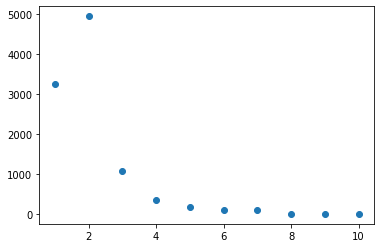

2 players
{'High Card': 1533, 'Pair': 5545, 'Two Pair': 1667, 'Trips': 593, 'Straight': 300, 'Flush': 179, 'Full House': 161, 'Quads': 19, 'Straight Flush': 3, 'Royal Flush': 0}


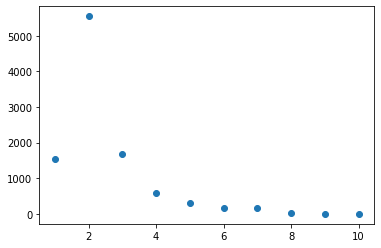

3 players
{'High Card': 705, 'Pair': 5400, 'Two Pair': 2150, 'Trips': 870, 'Straight': 390, 'Flush': 258, 'Full House': 204, 'Quads': 21, 'Straight Flush': 2, 'Royal Flush': 0}


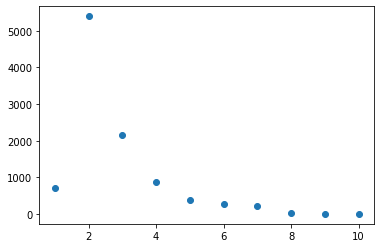

4 players
{'High Card': 314, 'Pair': 5143, 'Two Pair': 2327, 'Trips': 1048, 'Straight': 518, 'Flush': 323, 'Full House': 298, 'Quads': 25, 'Straight Flush': 4, 'Royal Flush': 0}


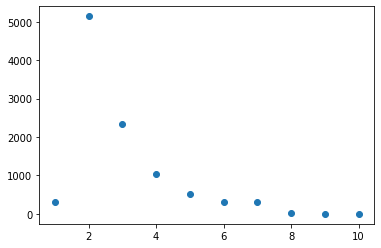

5 players
{'High Card': 143, 'Pair': 4606, 'Two Pair': 2517, 'Trips': 1291, 'Straight': 676, 'Flush': 418, 'Full House': 317, 'Quads': 29, 'Straight Flush': 3, 'Royal Flush': 0}


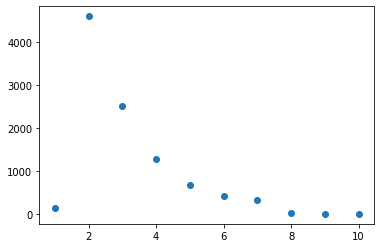

6 players
{'High Card': 43, 'Pair': 4247, 'Two Pair': 2578, 'Trips': 1540, 'Straight': 729, 'Flush': 451, 'Full House': 377, 'Quads': 35, 'Straight Flush': 0, 'Royal Flush': 0}


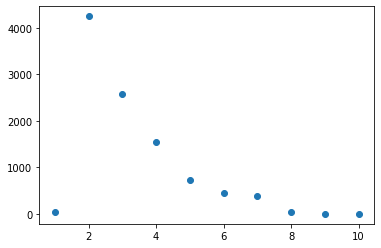

7 players
{'High Card': 27, 'Pair': 3891, 'Two Pair': 2599, 'Trips': 1605, 'Straight': 827, 'Flush': 519, 'Full House': 478, 'Quads': 47, 'Straight Flush': 7, 'Royal Flush': 0}


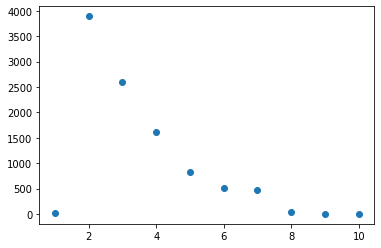

8 players
{'High Card': 4, 'Pair': 3572, 'Two Pair': 2665, 'Trips': 1763, 'Straight': 903, 'Flush': 552, 'Full House': 482, 'Quads': 55, 'Straight Flush': 4, 'Royal Flush': 0}


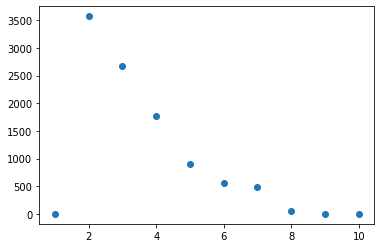

9 players
{'High Card': 2, 'Pair': 3194, 'Two Pair': 2617, 'Trips': 1872, 'Straight': 970, 'Flush': 654, 'Full House': 613, 'Quads': 68, 'Straight Flush': 10, 'Royal Flush': 0}


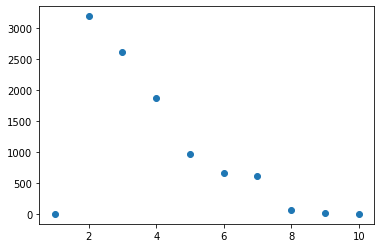

10 players
{'High Card': 3, 'Pair': 3017, 'Two Pair': 2528, 'Trips': 2012, 'Straight': 1099, 'Flush': 656, 'Full House': 625, 'Quads': 54, 'Straight Flush': 6, 'Royal Flush': 0}


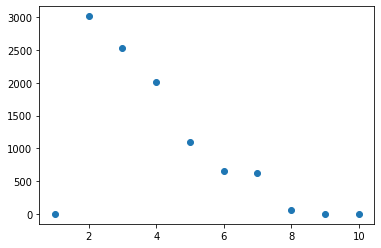

In [248]:
for i in range(1, 11):
    simulate(i)

{1: 7194, 2: 53964, 3: 21219, 4: 8286, 5: 4260, 6: 2612, 7: 2229, 8: 212, 9: 24, 10: 0}


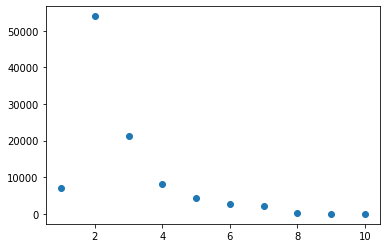

In [224]:
results = {i: 0 for i in range(1,11)}

for i in range(100000):
    g = Game(3, 10)
    g.deal()
    g.flop()
    g.turn()
    g.river
#     g.get_winning_hand()
    results[g.get_winning_hand()['score']] += 1
    
print(results)
    
plt.scatter(*zip(*results.items()))
plt.show()
    